In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.util import ngrams
import string
import unidecode
import time, math
import random

# Used by the model
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

# For model testing
from rouge import Rouge
from nltk.translate.bleu_score import corpus_bleu

# For plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# Prevent kernel from dying
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

/Users/faustotnc/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Loading The Data

In [2]:
# Reads the data
labeledPfd = pd.read_csv("./datasets/LabeledPoetryFoundationPoems.csv")
labeledPfd = labeledPfd.sample(frac=1) # randomizes the data

# Filters the poems by category
def get_poems_by_category(category):
    data = []
    for poem, emotion in zip(labeledPfd["poem"], labeledPfd["emotion"]):
        if emotion == category:
            data.append(poem)
    return data


# Gets the poems in each category
poems = {
    "joy": get_poems_by_category("joy"),
    "trust": get_poems_by_category("trust"),
    "sadness": get_poems_by_category("sadness"),
    "anticipation": get_poems_by_category("anticipation"),
    "fear": get_poems_by_category("fear"),
    "anger": get_poems_by_category("anger"),
    "disgust": get_poems_by_category("disgust"),
    "surprise": get_poems_by_category("surprise")
}

# Processing the Data

## The Batch Generator

In [3]:
class BatchGenerator(torch.utils.data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.outputs = targets
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        return self.inputs[index], self.outputs[index]

## The Data Processor

In [4]:
punctuation = " .,'\";?!:-"
digits = "0123456789"
valid_chars = string.ascii_lowercase + punctuation + digits

# For the word "Sunflower", if the input
# is ["S", "u", "n", "f", "l"], the expected
# output would be ["o"]
INPUT_SIZE = 5

class DataProcessor:
    def __init__(self, dataset, batch_size=48):
        full_data = list(dataset)
        
        # Only 50 documents for testing.
        # This number was chosen because of issues with speed
        # twentyPercent = math.ceil(len(full_data) * 0.2)
        self.test_set = full_data[:50]
        # The rest of the data as training data
        # eigtyPercent = math.floor(len(full_data) * 0.8)
        full_data = full_data[50:]

        def cleaner(poem_list):
            clean_data = []
            
            for poem in poem_list:
                # Adds the "poem start" symbol
                clean_data.append("<")
                
                poem_tokens = poem.split()
                for i in range(len(poem_tokens)):
                    current_token = poem_tokens[i]
                    next_token = "" if i == len(poem_tokens) - 1 else poem_tokens[i + 1]
                    
                    for char in current_token:
                        char.lower() # Only support lowercase characters
                        if (char in valid_chars): clean_data.append(char)
                            
                    # virtually adds a space after every token since
                    # nltk.word_tokenize() removes spaces, but only if
                    # the next token is not a punctuation
                    if (next_token not in punctuation or current_token != "-"):
                        clean_data.append(" ")
                    
                # Removes the last token (in case it is a space)
                last_token = clean_data.pop()
                # But if the last character is not
                # a space, then we put it back
                if (last_token != " "): clean_data.append(last_token)
                # Adds the "poem end" symbol
                clean_data.append(">")
            
            return clean_data

        # Cleans the data by emoving
        # punctuation from the dataset
        self.clean_data = cleaner(full_data)
        print("Number of tokens:", len(self.clean_data)) # Number of tokens

        # Extracts the vocabulary
        self.vocab = set(self.clean_data)
        self.voc_len = len(self.vocab)
        print("Vocabulary size:", self.voc_len)

        # Encodes the position of each word in the vocabulary
        self.word_to_ix = {word: i for i, word in enumerate(self.vocab)}

        # Generates character grams of size [input_size]
        self.embeddings = [
            (gram[:INPUT_SIZE], gram[INPUT_SIZE]) for gram in ngrams(self.clean_data, INPUT_SIZE + 1)
        ]
        self.num_embeddings = len(self.embeddings)
        print("Number of in-out pairs:", self.num_embeddings)
        print(self.embeddings[:3])
        
        # Training and Testing sets ready to be used
        self.train_set = BatchGenerator(*self.inp_tar_pairs())
        
    def inp_tar_pairs(self):
        inputs = []
        targets = []
        
        print("\nGenerating Input-Output Pairs...")
        
        embedding = 0
        for context, target in self.embeddings:
            embedding += 1
            # 2dim tensor with the positions of the context letters
            context_idxs = torch.tensor([self.word_to_ix[w] for w in context], dtype=torch.long)
            inputs.append(context_idxs)

            # 1dim tensor with the position of the target letter
            targ = torch.tensor([self.word_to_ix[target]], dtype=torch.long)
            targets.append(targ)
            
            # Prints a progress bar :)
            if embedding % 2000 == 0:
                barLength = 30
                progress = round(embedding / self.num_embeddings * 100)
                p = int((progress * barLength) / 100)
                bar = ("=" * p) + (" " * (barLength - p))
                other_info = f"Pair #{embedding} of {self.num_embeddings}"
                print(f":: [{bar}] {str(progress)}% Complete. {other_info}", end="\r")
            
        return inputs, targets 

# The Recurrent Neural Network (GRU)

In [5]:
class RNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(vocab_size, hidden_size)
        
        # We are using the GRU method to train the model
        self.gru = nn.GRU(
            hidden_size * INPUT_SIZE,
            hidden_size,
            n_layers,
            batch_first = True, # x: (num_embeddings, context_size, input_size)
        )
        self.decoder = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_vect, hidden):
        input_vect = self.encoder(input_vect.view(1, -1))
        input_vect = F.relu(input_vect)
        output, hidden = self.gru(input_vect.view(1, 1, -1), hidden)
        output = self.softmax(self.decoder(output.view(1, -1))) 
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
    
    def trainer(self, model, train_set):
        """
        Trains the model with the data for
        the equivalent of 1 epoch
        """
        
        # Initializes the hidden state
        hidden = self.init_hidden()

        # Initializes the gradients and the loss
        self.zero_grad()
        loss = 0

        # Trains the neural network over all
        # the character embeddings
        for inp, tar in train_set:
            # The model taken in a context tensor, and
            # the previous hidden state to predict an
            # output, and compute a new hidden state
            output, hidden = self.forward(inp, hidden)

            # The loss is computed using the predicted output
            # and the target (expected output)
            loss += model.criterion(output, tar)

        # Propagates the loss backwards
        # through the network
        loss.backward()
        model.model_optimizer.step()

        # Returns the loss of the network
        return loss.data.item() / model.data.num_embeddings

# The Model Class

In [6]:
class PoemModel:
    def __init__(self, data, n_epochs=1000):
        self.data = data
        
        # Model Hyperparameters
        self.n_epochs      = n_epochs
        self.print_every   = 1
        self.plot_every    = 1
        self.hidden_size   = 160
        self.n_layers      = 1
        self.learning_rate = 0.001
        self.batch_size    = 24
        
        # RNN Initialization
        self.model = RNN(data.voc_len, self.hidden_size, data.voc_len, self.n_layers)
        self.model_optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.CrossEntropyLoss()
    
    def train(self, plot_loss=True):
        total_time_start = time.time()
        all_losses = []
        loss_avg = 0

        # Converts the execution time
        # to a human-readible format
        def time_since(since):
            s = time.time() - since
            m = math.floor(s / 60)
            s -= m * 60
            return '%dm %ds' % (m, s)
        
        print("Training...")
        
        # Trains the model.
        for epoch in range(1, self.n_epochs + 1):
            start = time.time()
            
            # Divides the entire dataset into [batch_size] batches
            training_generator = torch.utils.data.DataLoader(self.data.train_set, 
                batch_size = self.batch_size,
                shuffle = True,
            )
            train_gen = iter(training_generator)
            
            # Only trains using [batch_size / 2] of the generated batches.
            # So if there were a total of 500 batches, and our batch_size
            # equals 20, then it will only train with 10 batches of 20
            # input-target pairs for the current epoch.
            for index in range(round(self.batch_size / 2)):
                # Trains the model for the
                # current epoch
                inp, tar = train_gen.next()
                loss = self.model.trainer(self, zip(inp, tar))  
                loss_avg += loss
                
            # Prints a progress bar :)
            barLength = 30
            progress = round(epoch / self.n_epochs * 100)
            p = int((progress * barLength) / 100)
            bar = ("=" * p) + (" " * (barLength - p))
            other_info = f"Epoch #{epoch} of {self.n_epochs}"
            print(f":: [{bar}] {str(progress)}% Complete. {other_info}", end="\r")

            # Saves the epoch execution time for later plotting
            all_losses.append(loss_avg / self.plot_every)
            loss_avg = 0

        # Prints the total time taken by training the model
        print("\nTotal training time:", time_since(total_time_start))
        
        # Plots the loss
        if plot_loss:
            plt.figure()
            plt.plot(all_losses)
        
        
    def generate(self, prime_str, predict_len=100, temperature=0.8):
        prime_str = prime_str.lower()
        hidden = self.model.init_hidden()

        for p in range(predict_len):
            prime_input = torch.tensor([self.data.word_to_ix[w] for w in list(prime_str)], dtype=torch.long)
            inp = prime_input[-INPUT_SIZE:] # last [INPUT_SIZE] chars as input
            output, hidden = self.model.forward(inp, hidden)

            # Sample from the network as a multinomial distribution
            output_dist = output.data.view(-1).div(temperature).exp()
            top_i = torch.multinomial(output_dist, 1)[0]

            # Add predicted word to string and use as next input
            predicted_word = list(self.data.word_to_ix.keys())[list(self.data.word_to_ix.values()).index(top_i)]
            
            if predicted_word == ">":
                break
            else:
                prime_str += predicted_word

        return prime_str

# The Model Evaluator

In [7]:
def evaluate_model(model):
    rouge = Rouge()

    # cleans a peom
    def clean_poem(poem):
        return ["".join([char for char in word.lower() if char in valid_chars])
                    for word in poem.split()]

    # list of poems with clean data as hypothesis for ROUGE
    rouge_hyp = [" ".join(clean_poem(poem)) for poem in model.data.test_set]
    rouge_refs = []

    # list of lists of poems with clean data as hypothesis for BLEU
    bleu_references = [clean_poem(poem) for poem in model.data.test_set]
    bleu_candidates = []

    for i in range(len(model.data.test_set)):
        first_chars = " ".join(list(rouge_hyp[i])[:INPUT_SIZE])
        gen_poem = model.generate(first_chars)
        gen_poem = [word for word in nltk.word_tokenize(gen_poem)]

        # for rouge
        rouge_refs.append(" ".join(gen_poem))

        # for bleu
        bleu_candidates.append(gen_poem)

    rouge_scores = rouge.get_scores(rouge_hyp, rouge_refs, avg=True)
    print("ROUGE SCORE:", rouge_scores)

    bleu_score = corpus_bleu(bleu_references, bleu_candidates)
    print("\nBLEU SCORE:", bleu_score)

# The Model for the "Joy" Category

In [8]:
joyData = DataProcessor(poems["joy"])

Number of tokens: 6056794
Vocabulary size: 48
Number of in-out pairs: 6056789
[(('<', 'f', 'o', 'r', ' '), 'l'), (('f', 'o', 'r', ' ', 'l'), 'l'), (('o', 'r', ' ', 'l', 'l'), 'e')]

Generating Input-Output Pairs...


Training...
:: [==============================] 100% Complete. Epoch #1000 of 1000
Total training time: 11m 58s


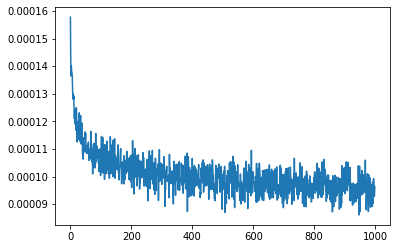

In [9]:
joyModel = PoemModel(joyData)
joyModel.train()

In [10]:
joyModel.generate("<Love")

'<love new the woan she hir apt to and on the diaker light and the late frow be the sing to the home you a'

From the above generated sentence, we can observe that the model was able to learn how to correctly separate words (with only once space between words), as well as the correct spelling of small words like "and", "the", and "that".

In [11]:
evaluate_model(joyModel)

ROUGE SCORE: {'rouge-1': {'f': 0.06816787460892197, 'p': 0.04283017483996642, 'r': 0.2628039389673573}, 'rouge-2': {'f': 0.002107223022469656, 'p': 0.001362943893278627, 'r': 0.010887747035573124}, 'rouge-l': {'f': 0.05579010201769253, 'p': 0.03520515147577734, 'r': 0.1907735094044019}}

BLEU SCORE: 0.06330113325436737


# The Model for the "Trust" Category

In [12]:
trustData = DataProcessor(poems["trust"])

Number of tokens: 6777485
Vocabulary size: 48
Number of in-out pairs: 6777480
[(('<', ' ', 'c', 'l', 'o'), 's'), ((' ', 'c', 'l', 'o', 's'), 'e'), (('c', 'l', 'o', 's', 'e'), ' ')]

Generating Input-Output Pairs...


Training...
:: [==============================] 100% Complete. Epoch #1000 of 1000
Total training time: 13m 48s


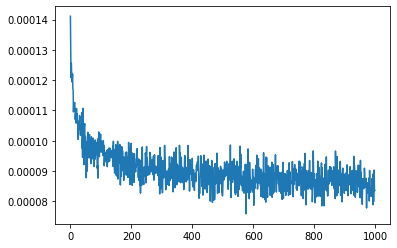

In [13]:
trustModel = PoemModel(trustData)
trustModel.train()

In [14]:
trustModel.generate("<Feel")

'<feely arkenst tounfio dexpey, me coust and pas amppe, that hoers to every, way the benit, enders frip. s'

In [15]:
evaluate_model(trustModel)

ROUGE SCORE: {'rouge-1': {'f': 0.061449751550437345, 'p': 0.03834814022025178, 'r': 0.25213156994245917}, 'rouge-2': {'f': 0.00161167730482412, 'p': 0.0009049783551111915, 'r': 0.008992640692640693}, 'rouge-l': {'f': 0.06002823888875649, 'p': 0.03845054593199813, 'r': 0.20398427125887075}}

BLEU SCORE: 0.07045185985373457


# The Model for the "Sadness" Category

In [16]:
sadnessData = DataProcessor(poems["sadness"])

Number of tokens: 1890762
Vocabulary size: 48
Number of in-out pairs: 1890757
[(('<', 'n', 'c', 'e', ' '), 'm'), (('n', 'c', 'e', ' ', 'm'), 'o'), (('c', 'e', ' ', 'm', 'o'), 'r')]

Generating Input-Output Pairs...


Training...
:: [==============================] 100% Complete. Epoch #1000 of 1000
Total training time: 6m 59s


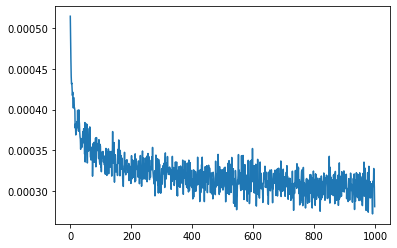

In [17]:
sadnessModel = PoemModel(sadnessData)
sadnessModel.train()

In [18]:
sadnessModel.generate("<Tear")

'<tear hoke the lome, nd can breath stilen and caser white criith wall ownelt. o and then  asm home coneed'

In [19]:
evaluate_model(sadnessModel)

ROUGE SCORE: {'rouge-1': {'f': 0.06053457376307031, 'p': 0.0377327733265015, 'r': 0.21836668109414106}, 'rouge-2': {'f': 0.0020201421517741618, 'p': 0.0011863754050357794, 'r': 0.008540993788819876}, 'rouge-l': {'f': 0.05678164944947081, 'p': 0.03622463662389178, 'r': 0.17388191314525958}}

BLEU SCORE: 0.06568112305169231


# The Model for the "Anticipation" Category

In [20]:
anticipationData = DataProcessor(poems["anticipation"])

Number of tokens: 1598646
Vocabulary size: 48
Number of in-out pairs: 1598641
[(('<', 'i', 'c', 'e', ' '), 's'), (('i', 'c', 'e', ' ', 's'), 'p'), (('c', 'e', ' ', 's', 'p'), 'r')]

Generating Input-Output Pairs...


Training...
:: [==============================] 100% Complete. Epoch #1000 of 1000
Total training time: 6m 25s


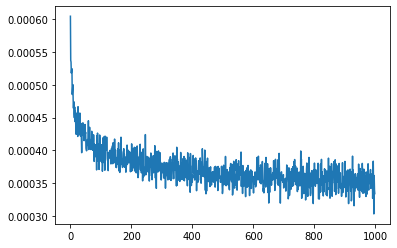

In [21]:
anticipationModel = PoemModel(anticipationData)
anticipationModel.train()

In [22]:
anticipationModel.generate("<Hope")

'<hopeaddian, when the someterion a comes, with in and t to ever grived and lut end the said. t mill n hat'

In [23]:
evaluate_model(anticipationModel)

ROUGE SCORE: {'rouge-1': {'f': 0.07835251148295427, 'p': 0.05017076594946051, 'r': 0.2674169480971581}, 'rouge-2': {'f': 0.002203181310160996, 'p': 0.001262226222840987, 'r': 0.010777240472892646}, 'rouge-l': {'f': 0.06122951448937185, 'p': 0.03959733592422694, 'r': 0.18164031187773946}}

BLEU SCORE: 0.06600027176631756


# The Model for the "Fear" Category

In [24]:
fearData = DataProcessor(poems["fear"])

Number of tokens: 1668814
Vocabulary size: 48
Number of in-out pairs: 1668809
[(('<', 'o', 'm', 'e', ','), ' '), (('o', 'm', 'e', ',', ' '), 's'), (('m', 'e', ',', ' ', 's'), 'u')]

Generating Input-Output Pairs...


Training...
:: [==============================] 100% Complete. Epoch #1000 of 1000
Total training time: 6m 37s


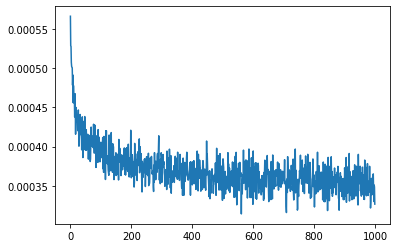

In [25]:
fearModel = PoemModel(fearData)
fearModel.train()

In [26]:
fearModel.generate("<Fear")

'<fears and she stame., her so the bain ever of the tawes blaits and herrat, a sor the streers in the mani'

In [27]:
evaluate_model(fearModel)

ROUGE SCORE: {'rouge-1': {'f': 0.06063475846773179, 'p': 0.03731699793889177, 'r': 0.24357668451266648}, 'rouge-2': {'f': 0.0022283709246757105, 'p': 0.0012522277506657217, 'r': 0.0153613154960981}, 'rouge-l': {'f': 0.05518050549681793, 'p': 0.03492954238155375, 'r': 0.17990082808114846}}

BLEU SCORE: 0.0657949642414411


# The Model for the "Anger" Category

In [28]:
angerData = DataProcessor(poems["anger"])

Number of tokens: 113828
Vocabulary size: 48
Number of in-out pairs: 113823
[(('<', ' ', 's', 't', 'a'), 'y'), ((' ', 's', 't', 'a', 'y'), ' '), (('s', 't', 'a', 'y', ' '), 'o')]

Generating Input-Output Pairs...


Training...
:: [==============================] 100% Complete. Epoch #1000 of 1000
Total training time: 5m 13s


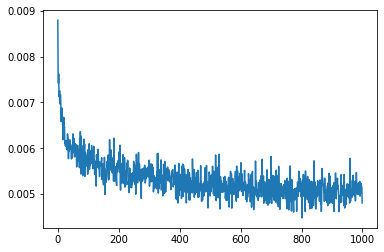

In [29]:
angerModel = PoemModel(angerData)
angerModel.train()

In [30]:
angerModel.generate("<Rage")

'<rage toom dear anse dele  with of revings and enend the spartirshlese streaturees.a was  says, chell, o '

In [31]:
evaluate_model(angerModel)

ROUGE SCORE: {'rouge-1': {'f': 0.08429297392858741, 'p': 0.05837870585910867, 'r': 0.20513532455106667}, 'rouge-2': {'f': 0.0028380805158796157, 'p': 0.001954776129052537, 'r': 0.007938110038110036}, 'rouge-l': {'f': 0.07637850726225513, 'p': 0.054760429643228095, 'r': 0.16121751028867737}}

BLEU SCORE: 0.07932743799926341


# The Model for the "Disgust" Category

In [32]:
disgustData = DataProcessor(poems["disgust"])

Number of tokens: 42800
Vocabulary size: 48
Number of in-out pairs: 42795
[(('<', 'a', 't', 'e', ' '), 'a'), (('a', 't', 'e', ' ', 'a'), 'f'), (('t', 'e', ' ', 'a', 'f'), 't')]

Generating Input-Output Pairs...


Training...
:: [==============================] 100% Complete. Epoch #1000 of 1000
Total training time: 5m 16s


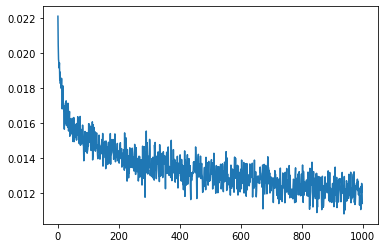

In [33]:
disgustModel = PoemModel(disgustData)
disgustModel.train()

In [34]:
disgustModel.generate("<Guts")

'<guts done-shurpownings and to gones, his on scouls of youdhor en the burn ties and on hand have to roels'

In [35]:
evaluate_model(disgustModel)

ROUGE SCORE: {'rouge-1': {'f': 0.060607765872905485, 'p': 0.04292483967619461, 'r': 0.15794617763793967}, 'rouge-2': {'f': 0.0009190697458892438, 'p': 0.0005325500811124888, 'r': 0.004181220229046316}, 'rouge-l': {'f': 0.05945986393188673, 'p': 0.043701855078547756, 'r': 0.13040026339454255}}

BLEU SCORE: 0.08103760095550393
